In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm

In [2]:
csv_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\00_data\data\MergedGrainsData.xlsx"
df = pd.read_excel(csv_path, header=1)

df.head()

,merged ID,merged parent area,M.P. major axis,M.P. aspect ratio,M.P. percent internal boundary length,GOS,Count Parent grains,Total Parent Area,Count Twin grains,Total Twinned Area,...,Schmid SF5,Schmid SF6,Taylor TF1,Taylor TF2,Taylor TF3,Taylor TF4,Taylor TF5,Taylor TF6,Neighbor Count,Neighbor Grain IDs
0,1,31,11.418951,3.303548,61.764706,0.777758,1,31,0,0,...,0.320974,0.470227,2.136972,2.846960,3.064860,2.262581,3.064860,2.262581,3,"4,436,437"
1,2,11,5.961390,2.537420,77.272727,0.552923,1,11,0,0,...,0.379885,0.444008,2.080153,2.957410,3.329539,2.229734,2.960449,2.229734,1,452
2,3,17,5.817101,1.563343,90.476190,0.594562,1,17,0,0,...,0.498814,0.498814,2.329955,2.025140,2.179495,2.179495,2.179495,2.179495,3,"16,26,446"
3,4,53,14.193203,2.985210,63.414634,0.238788,1,53,0,0,...,0.386806,0.468478,1.793094,2.465554,2.436545,2.211377,2.436545,2.211377,4,"1,12,35,437"
4,5,22,5.671130,1.148170,86.956522,0.227919,1,22,0,0,...,0.458077,0.496923,1.566975,1.806176,1.788028,1.788028,1.788028,1.788028,3,"13,445,458"


In [55]:
df.columns

Index(['merged ID', 'merged parent area', 'M.P. major axis',
       'M.P. aspect ratio', 'M.P. percent internal boundary length', 'GOS',
       'Count Parent grains', 'Total Parent Area', 'Count Twin grains',
       'Total Twinned Area', 'Total Other Area',
       'Percent of grain that twinned', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var4', 'Schmid for Var5',
       'Schmid for Var6', 'Area Twinned for Var1', 'Area Twinned for Var2',
       'Area Twinned for Var3', 'Area Twinned for Var4',
       'Area Twinned for Var5', 'Area Twinned for Var6', 'Rank for Var1',
       'Rank for Var2', 'Rank for Var3', 'Rank for Var4', 'Rank for Var5',
       'Rank for Var6', 'Twin Count for Var1', 'Twin Count for Var2',
       'Twin Count for Var3', 'Twin Count for Var4', 'Twin Count for Var5',
       'Twin Count for Var6', 'M.P. total boundary length',
       'M.P. border boundary length', 'Parent grain', 'total other twins',
       'total area of other twins', '

In [295]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'merged parent area',
    'M.P. major axis',
    'M.P. aspect ratio',
    'GOS',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'GAM',
    'Phi1',
    'Phi',
    'Phi2',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
]
EDGE_COL = 'Neighbor Grain IDs'

VAGUE_COLS = ['M.P. total boundary length', 'merged parent area',]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

In [296]:
y = (~df["Percent of grain that twinned"].isna()).map(int).to_numpy()

In [297]:
sum(y)

np.int64(116)

In [298]:
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   merged parent area  556 non-null    int64  
 1   M.P. major axis     556 non-null    float64
 2   M.P. aspect ratio   556 non-null    float64
 3   GOS                 556 non-null    float64
 4   Schmid for Var1     556 non-null    float64
 5   Schmid for Var2     556 non-null    float64
 6   Schmid for Var3     556 non-null    float64
 7   Schmid for Var4     556 non-null    float64
 8   Schmid for Var5     556 non-null    float64
 9   Schmid for Var6     556 non-null    float64
 10  GAM                 556 non-null    float64
 11  Phi1                556 non-null    float64
 12  Phi                 556 non-null    float64
 13  Phi2                556 non-null    float64
 14  Schmid SF1          556 non-null    float64
 15  Schmid SF2          556 non-null    float64
 16  Schmid S

In [299]:
df[FEATURE_COLS].describe()

,merged parent area,M.P. major axis,M.P. aspect ratio,GOS,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,...,Schmid SF3,Schmid SF4,Schmid SF5,Schmid SF6,Taylor TF1,Taylor TF2,Taylor TF3,Taylor TF4,Taylor TF5,Taylor TF6
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,...,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,378.717626,22.041835,1.944941,0.815037,-0.029876,-0.028650,-0.089480,-0.089463,-0.032030,-0.033273,...,0.397973,0.345271,0.417507,0.469696,3.117065,2.495359,2.625999,2.186902,2.541564,2.186902
std,894.719579,20.600790,1.225898,1.029579,0.252770,0.253761,0.261603,0.263904,0.212977,0.211375,...,0.080784,0.097375,0.067357,0.023282,1.789735,0.502685,0.535096,0.131231,0.451137,0.131231
min,10.000000,3.934175,1.011458,0.081182,-0.497607,-0.497533,-0.494256,-0.499242,-0.478946,-0.493438,...,0.199212,0.154567,0.240463,0.407622,0.343051,1.728016,1.671070,1.671070,1.671070,1.671070
25%,42.000000,9.408231,1.382717,0.238839,-0.237504,-0.235677,-0.319444,-0.321071,-0.173901,-0.178136,...,0.336542,0.266259,0.369020,0.450301,2.050441,2.090709,2.161594,2.119063,2.161594,2.119063
50%,118.000000,16.657681,1.646023,0.336865,-0.010009,-0.009470,-0.099047,-0.100999,-0.025967,-0.029444,...,0.411386,0.357212,0.433389,0.472221,2.343809,2.398419,2.464556,2.190780,2.429161,2.190780
75%,295.250000,26.502485,2.053281,0.862920,0.158676,0.157748,0.096899,0.099201,0.066783,0.068265,...,0.472161,0.431320,0.476665,0.492381,3.660945,2.881138,3.102365,2.281140,2.934297,2.281140
max,8682.000000,198.455897,14.103105,7.110221,0.493265,0.492180,0.494435,0.490865,0.489465,0.494165,...,0.499897,0.499867,0.499997,0.499997,10.000000,3.948792,3.747032,2.402268,3.492716,2.402268


In [300]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        new = [i, e-1]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [301]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 389
len(val_indices) = 83
len(test_indices) = 84
split done!


In [302]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [303]:
X_train = df.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (389, 26) / (83, 26) / (84, 26)
y_train.shape = (389,) / (83,) / (84,)


In [304]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [305]:
X = np.zeros_like(df[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [306]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [307]:
data

Data(x=[556, 26], edge_index=[2, 3074], y=[556], train_mask=[556], val_mask=[556], test_mask=[556])

In [308]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,merged parent area,M.P. major axis,M.P. aspect ratio,GOS,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,...,Schmid SF3,Schmid SF4,Schmid SF5,Schmid SF6,Taylor TF1,Taylor TF2,Taylor TF3,Taylor TF4,Taylor TF5,Taylor TF6
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,...,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,-0.003988,-0.018495,-0.018334,0.010055,-0.012329,-0.014079,-0.026351,-0.025651,-0.047391,-0.046228,...,0.025202,0.030465,0.009895,0.017005,0.005331,-0.047367,-0.040076,-0.025641,-0.050088,-0.025641
std,1.060606,0.987099,0.992013,1.056912,0.970104,0.973073,0.990515,0.989216,1.001312,1.003519,...,1.011915,1.009151,1.006993,1.002598,0.983082,0.994384,1.003065,1.020877,0.990164,1.020877
min,-0.441068,-0.886134,-0.773721,-0.743282,-1.807429,-1.812057,-1.558967,-1.561661,-2.148574,-2.230896,...,-2.464523,-1.945902,-2.636905,-2.656101,-1.518404,-1.565283,-1.830140,-4.038424,-1.960663,-4.038424
25%,-0.403136,-0.623841,-0.473293,-0.581439,-0.809180,-0.807946,-0.897069,-0.893806,-0.714400,-0.733974,...,-0.744304,-0.788373,-0.714981,-0.818206,-0.580553,-0.847823,-0.910627,-0.553372,-0.884052,-0.553372
50%,-0.313045,-0.276480,-0.260222,-0.480811,0.063917,0.059467,-0.062576,-0.068893,-0.018885,-0.028050,...,0.193208,0.154222,0.247341,0.125717,-0.419410,-0.239128,-0.342710,0.004530,-0.296792,0.004530
75%,-0.102931,0.195240,0.069336,0.059210,0.711315,0.700680,0.679340,0.681537,0.417177,0.435834,...,0.954495,0.922244,0.894310,0.993846,0.304079,0.715758,0.852897,0.707459,0.811891,0.707459
max,9.838771,8.434485,9.820211,6.472363,1.995428,1.983092,2.184545,2.149643,2.404420,2.457828,...,1.301916,1.632630,1.243128,1.321837,3.786053,2.827732,2.061357,1.649747,2.037519,1.649747


In [309]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

In [310]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


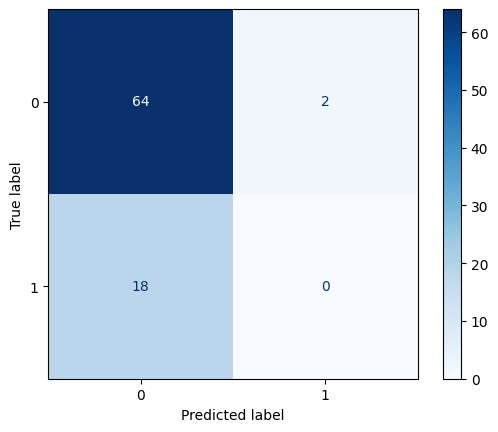

Accuracy: 0.7619
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [311]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [312]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


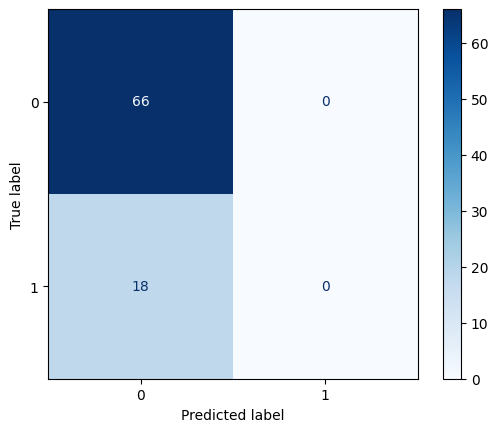

Accuracy: 0.7857
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [313]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [314]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


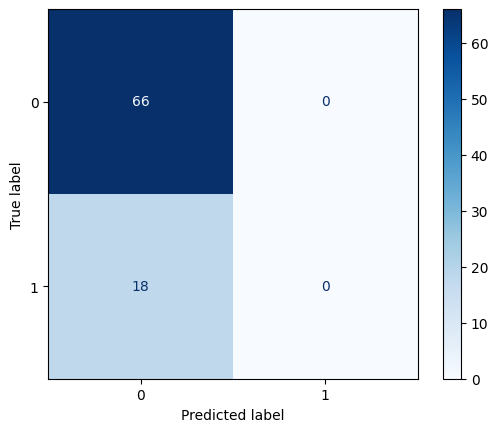

Accuracy: 0.7857
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [315]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [316]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [317]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

339,138
MLP model number of params: 339,138


In [318]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask].to(dtype=torch.long)
    preds = model(X_tmp)  # Perform a single forward pass.
    loss = criterion(log_softmax(preds), y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask].to(dtype=torch.long)
        v_preds = model(v_X_tmp)
        v_loss = criterion(log_softmax(v_preds), v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6882 / Val_loss: 0.6851
Epoch: 002, Train_loss: 0.6875 / Val_loss: 0.6836
Epoch: 003, Train_loss: 0.6855 / Val_loss: 0.6821
Epoch: 004, Train_loss: 0.6831 / Val_loss: 0.6806
Epoch: 005, Train_loss: 0.6848 / Val_loss: 0.6791
Epoch: 006, Train_loss: 0.6817 / Val_loss: 0.6777
Epoch: 007, Train_loss: 0.6803 / Val_loss: 0.6762
Epoch: 008, Train_loss: 0.6777 / Val_loss: 0.6746
Epoch: 009, Train_loss: 0.6783 / Val_loss: 0.6730
Epoch: 010, Train_loss: 0.6751 / Val_loss: 0.6714
Epoch: 011, Train_loss: 0.6747 / Val_loss: 0.6697
Epoch: 012, Train_loss: 0.6734 / Val_loss: 0.6680
Epoch: 013, Train_loss: 0.6747 / Val_loss: 0.6661
Epoch: 014, Train_loss: 0.6746 / Val_loss: 0.6643
Epoch: 015, Train_loss: 0.6775 / Val_loss: 0.6627
Epoch: 016, Train_loss: 0.6646 / Val_loss: 0.6609
Epoch: 017, Train_loss: 0.6712 / Val_loss: 0.6593
Epoch: 018, Train_loss: 0.6674 / Val_loss: 0.6577
Epoch: 019, Train_loss: 0.6673 / Val_loss: 0.6560
Epoch: 020, Train_loss: 0.6749 / Val_loss: 0.6546


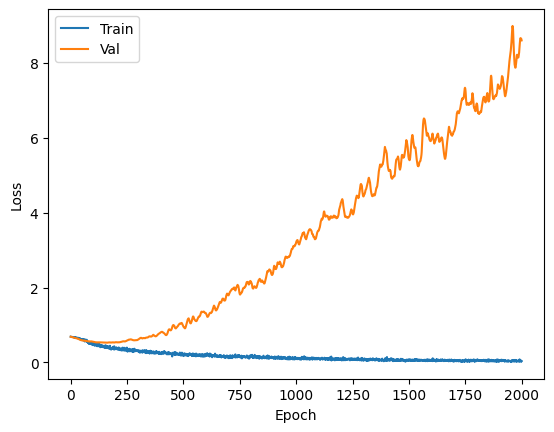

In [319]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

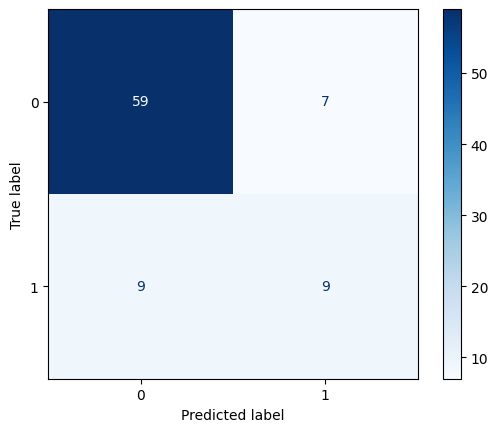

Accuracy: 0.8095
Precision: 0.5625
Recall: 0.5000
f1 score: 0.5294


In [320]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
out = model(X_tmp_test)
pred = out.argmax(dim=1)  # Use the class with highest probability.

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [321]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 2)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

341,826
GCN model number of params: 341,826


In [322]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask].squeeze()
    loss = criterion(log_softmax(preds), data.y[data.train_mask].to(dtype=torch.long))  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask].squeeze()
        v_loss = criterion(log_softmax(v_preds), data.y[data.val_mask].to(dtype=torch.long))
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8221 / Val_loss: 0.8570
Epoch: 002, Train_loss: 0.7607 / Val_loss: 0.7261
Epoch: 003, Train_loss: 0.7550 / Val_loss: 0.8398
Epoch: 004, Train_loss: 0.7822 / Val_loss: 0.7582
Epoch: 005, Train_loss: 0.7208 / Val_loss: 0.8050
Epoch: 006, Train_loss: 0.7443 / Val_loss: 0.7122
Epoch: 007, Train_loss: 0.7298 / Val_loss: 0.6933
Epoch: 008, Train_loss: 0.7257 / Val_loss: 0.7115
Epoch: 009, Train_loss: 0.7552 / Val_loss: 0.7339
Epoch: 010, Train_loss: 0.6908 / Val_loss: 0.6563
Epoch: 011, Train_loss: 0.6958 / Val_loss: 0.6859
Epoch: 012, Train_loss: 0.7203 / Val_loss: 0.7185
Epoch: 013, Train_loss: 0.6947 / Val_loss: 0.6023
Epoch: 014, Train_loss: 0.6896 / Val_loss: 0.6796
Epoch: 015, Train_loss: 0.7034 / Val_loss: 0.7772
Epoch: 016, Train_loss: 0.6859 / Val_loss: 0.6797
Epoch: 017, Train_loss: 0.6715 / Val_loss: 0.7183
Epoch: 018, Train_loss: 0.6676 / Val_loss: 0.6965
Epoch: 019, Train_loss: 0.7092 / Val_loss: 0.7068
Epoch: 020, Train_loss: 0.7023 / Val_loss: 0.6631


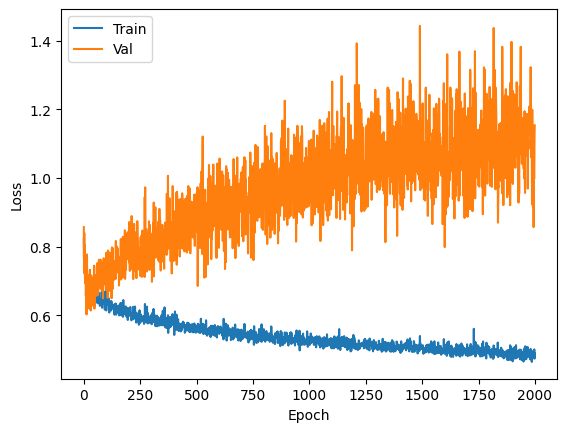

In [323]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [324]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.
y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

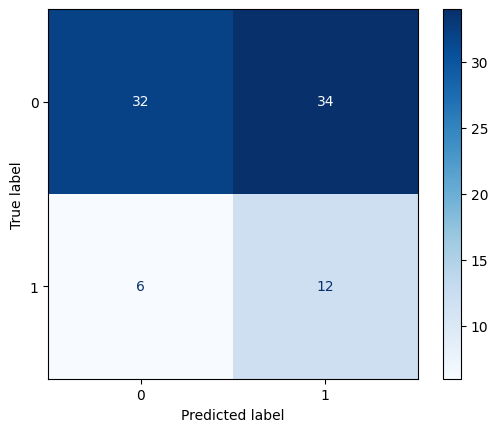

Accuracy: 0.5238
Precision: 0.2609
Recall: 0.6667
f1 score: 0.3750


In [325]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [326]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        return x

model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

341,830
GAT model number of params: 341,830


In [327]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask].squeeze()
    loss = criterion(log_softmax(preds), data.y[data.train_mask].to(dtype=torch.long))  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask].squeeze()
        v_loss = criterion(log_softmax(v_preds), data.y[data.val_mask].to(dtype=torch.long))
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7002 / Val_loss: 0.6990
Epoch: 002, Train_loss: 0.6948 / Val_loss: 0.6903
Epoch: 003, Train_loss: 0.6895 / Val_loss: 0.6901
Epoch: 004, Train_loss: 0.6891 / Val_loss: 0.6888
Epoch: 005, Train_loss: 0.6848 / Val_loss: 0.6817
Epoch: 006, Train_loss: 0.6820 / Val_loss: 0.6784
Epoch: 007, Train_loss: 0.6838 / Val_loss: 0.6780
Epoch: 008, Train_loss: 0.6758 / Val_loss: 0.6709
Epoch: 009, Train_loss: 0.6802 / Val_loss: 0.6722
Epoch: 010, Train_loss: 0.6762 / Val_loss: 0.6653
Epoch: 011, Train_loss: 0.6753 / Val_loss: 0.6668
Epoch: 012, Train_loss: 0.6744 / Val_loss: 0.6656
Epoch: 013, Train_loss: 0.6766 / Val_loss: 0.6629
Epoch: 014, Train_loss: 0.6733 / Val_loss: 0.6671
Epoch: 015, Train_loss: 0.6711 / Val_loss: 0.6575
Epoch: 016, Train_loss: 0.6732 / Val_loss: 0.6539
Epoch: 017, Train_loss: 0.6689 / Val_loss: 0.6584
Epoch: 018, Train_loss: 0.6724 / Val_loss: 0.6458
Epoch: 019, Train_loss: 0.6697 / Val_loss: 0.6555
Epoch: 020, Train_loss: 0.6653 / Val_loss: 0.6594


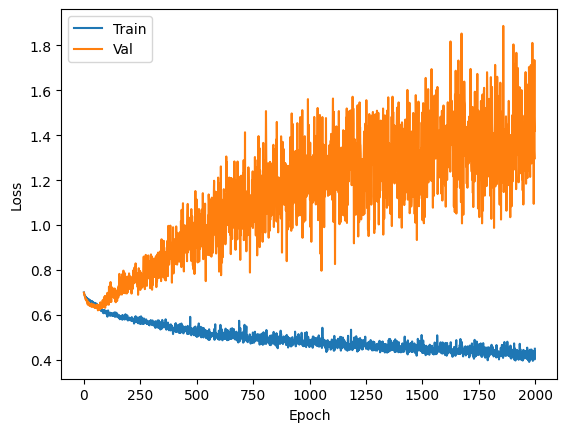

In [328]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [329]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.
y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

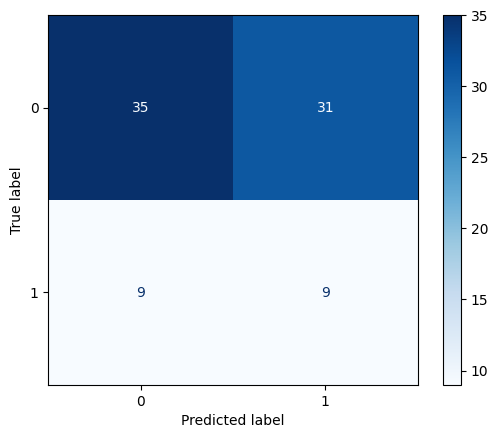

Accuracy: 0.5238
Precision: 0.2250
Recall: 0.5000
f1 score: 0.3103


In [330]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 외곽선에 걸친 샘플 제거

In [331]:
BORDER_COL = 'M.P. border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [332]:
indices_included = df_inside["merged ID"].tolist()

edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    for e in e_list:
        if e in indices_included:
            idx = df_inside.index[df_inside["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [333]:
edge_index_2

tensor([[  0,   0,   1,  ..., 480, 480, 480],
        [  1, 389,   0,  ..., 380, 475, 477]])

In [334]:
d = pd.DataFrame(edge_index_2.t())

In [335]:
sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

In [336]:
y = (~df_inside["Percent of grain that twinned"].isna()).map(int).to_numpy()

In [337]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 336
len(val_indices) = 72
len(test_indices) = 73
split done!


In [338]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [339]:
X_train = df_inside.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df_inside.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df_inside.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (336, 26) / (72, 26) / (73, 26)
y_train.shape = (336,) / (72,) / (73,)


In [340]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [341]:
X = np.zeros_like(df_inside[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [342]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [343]:
data

Data(x=[481, 26], edge_index=[2, 2420], y=[481], train_mask=[481], val_mask=[481], test_mask=[481])

In [344]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,merged parent area,M.P. major axis,M.P. aspect ratio,GOS,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,...,Schmid SF3,Schmid SF4,Schmid SF5,Schmid SF6,Taylor TF1,Taylor TF2,Taylor TF3,Taylor TF4,Taylor TF5,Taylor TF6
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,0.051675,0.056287,0.014602,0.065761,-0.068053,-0.068871,-0.038275,-0.039614,-0.063793,-0.060608,...,-0.005043,-0.018380,-0.029685,0.020217,0.034459,-0.026234,-0.012887,-0.000475,-0.027544,-0.000475
std,1.160957,1.096437,1.042331,1.071293,0.984204,0.981220,0.960567,0.960851,0.977547,0.976719,...,1.001958,1.000100,1.027037,0.995778,1.013476,0.969551,1.003859,1.019893,0.994575,1.019893
min,-0.444032,-0.930698,-0.756616,-0.674776,-1.856827,-1.847090,-1.537449,-1.544332,-2.149953,-2.229914,...,-2.423593,-1.972551,-2.686199,-2.645639,-1.280158,-1.502252,-1.810494,-3.974721,-1.942829,-3.974721
25%,-0.389650,-0.604446,-0.429439,-0.500579,-0.862927,-0.856619,-0.887019,-0.891115,-0.677592,-0.648619,...,-0.769632,-0.889969,-0.771405,-0.765064,-0.567027,-0.800843,-0.885758,-0.525523,-0.869314,-0.525523
50%,-0.270690,-0.231602,-0.221137,-0.405004,-0.012317,0.021075,-0.058941,-0.064036,-0.015855,-0.024202,...,0.179622,0.112454,0.228769,0.118833,-0.433828,-0.237781,-0.323943,-0.009961,-0.306065,-0.009961
75%,-0.002180,0.351596,0.124486,-0.093494,0.652407,0.662274,0.643735,0.639252,0.395085,0.404812,...,0.874513,0.803447,0.853427,0.959748,0.364962,0.711490,0.892147,0.741166,0.858450,0.741166
max,10.965936,10.731805,10.893488,6.321528,2.034974,1.993670,2.161261,2.134987,2.393950,2.453829,...,1.266005,1.578006,1.227104,1.333607,4.065437,2.780073,2.129937,1.667139,2.071183,1.667139


In [345]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


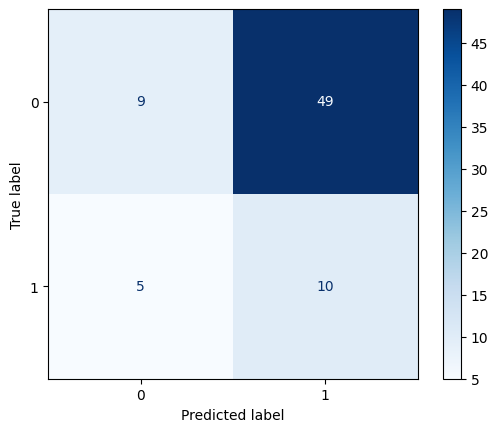

Accuracy: 0.2603
Precision: 0.1695
Recall: 0.6667
f1 score: 0.2703


In [346]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [347]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


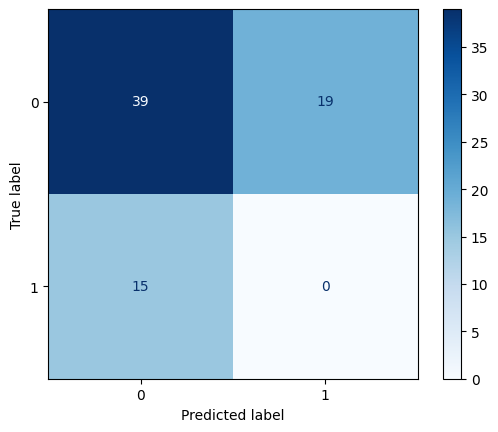

Accuracy: 0.5342
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [348]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [349]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


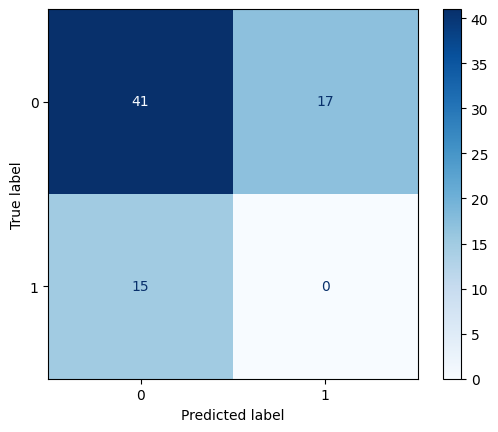

Accuracy: 0.5616
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [350]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [351]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [352]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

339,138
MLP model number of params: 339,138


In [353]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask].to(dtype=torch.long)
    preds = model(X_tmp)  # Perform a single forward pass.
    loss = criterion(log_softmax(preds), y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask].to(dtype=torch.long)
        v_preds = model(v_X_tmp)
        v_loss = criterion(log_softmax(v_preds), v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6851 / Val_loss: 0.6853
Epoch: 002, Train_loss: 0.6845 / Val_loss: 0.6836
Epoch: 003, Train_loss: 0.6813 / Val_loss: 0.6820
Epoch: 004, Train_loss: 0.6795 / Val_loss: 0.6803
Epoch: 005, Train_loss: 0.6778 / Val_loss: 0.6786
Epoch: 006, Train_loss: 0.6759 / Val_loss: 0.6768
Epoch: 007, Train_loss: 0.6724 / Val_loss: 0.6749
Epoch: 008, Train_loss: 0.6676 / Val_loss: 0.6729
Epoch: 009, Train_loss: 0.6672 / Val_loss: 0.6707
Epoch: 010, Train_loss: 0.6621 / Val_loss: 0.6684
Epoch: 011, Train_loss: 0.6647 / Val_loss: 0.6661
Epoch: 012, Train_loss: 0.6593 / Val_loss: 0.6637
Epoch: 013, Train_loss: 0.6578 / Val_loss: 0.6612
Epoch: 014, Train_loss: 0.6599 / Val_loss: 0.6589
Epoch: 015, Train_loss: 0.6648 / Val_loss: 0.6568
Epoch: 016, Train_loss: 0.6550 / Val_loss: 0.6548
Epoch: 017, Train_loss: 0.6499 / Val_loss: 0.6529
Epoch: 018, Train_loss: 0.6512 / Val_loss: 0.6511
Epoch: 019, Train_loss: 0.6548 / Val_loss: 0.6494
Epoch: 020, Train_loss: 0.6594 / Val_loss: 0.6481


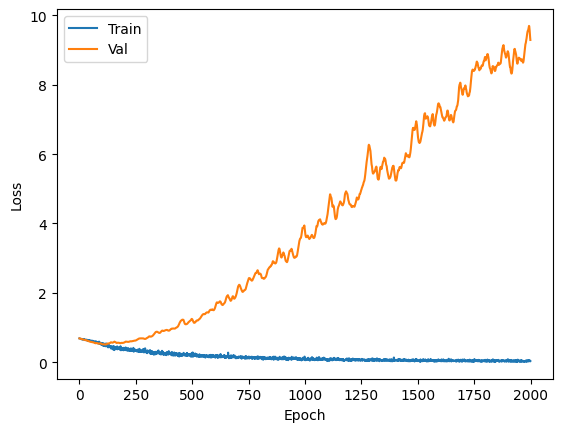

In [354]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

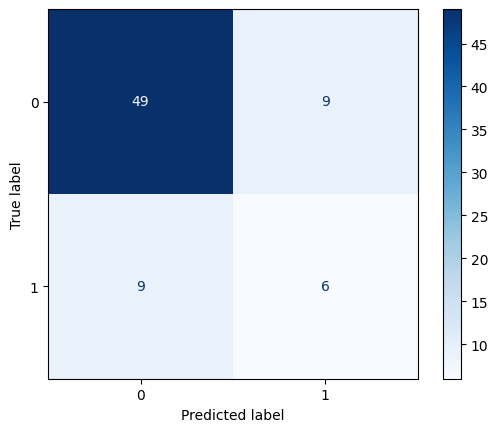

Accuracy: 0.7534
Precision: 0.4000
Recall: 0.4000
f1 score: 0.4000


In [355]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
out = model(X_tmp_test)
pred = out.argmax(dim=1)  # Use the class with highest probability.

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [356]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 2)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

341,826
GCN model number of params: 341,826


In [357]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask].squeeze()
    loss = criterion(log_softmax(preds), data.y[data.train_mask].to(dtype=torch.long))  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask].squeeze()
        v_loss = criterion(log_softmax(v_preds), data.y[data.val_mask].to(dtype=torch.long))
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7452 / Val_loss: 0.7680
Epoch: 002, Train_loss: 0.7418 / Val_loss: 0.6620
Epoch: 003, Train_loss: 0.6977 / Val_loss: 0.6223
Epoch: 004, Train_loss: 0.7107 / Val_loss: 0.6979
Epoch: 005, Train_loss: 0.6887 / Val_loss: 0.7121
Epoch: 006, Train_loss: 0.6633 / Val_loss: 0.6997
Epoch: 007, Train_loss: 0.6466 / Val_loss: 0.6671
Epoch: 008, Train_loss: 0.6691 / Val_loss: 0.7069
Epoch: 009, Train_loss: 0.6298 / Val_loss: 0.6525
Epoch: 010, Train_loss: 0.7389 / Val_loss: 0.6048
Epoch: 011, Train_loss: 0.7366 / Val_loss: 0.6546
Epoch: 012, Train_loss: 0.6777 / Val_loss: 0.6472
Epoch: 013, Train_loss: 0.6470 / Val_loss: 0.6687
Epoch: 014, Train_loss: 0.6735 / Val_loss: 0.5949
Epoch: 015, Train_loss: 0.6605 / Val_loss: 0.6245
Epoch: 016, Train_loss: 0.6499 / Val_loss: 0.6223
Epoch: 017, Train_loss: 0.6770 / Val_loss: 0.5713
Epoch: 018, Train_loss: 0.6372 / Val_loss: 0.6056
Epoch: 019, Train_loss: 0.6385 / Val_loss: 0.5703
Epoch: 020, Train_loss: 0.6298 / Val_loss: 0.6150


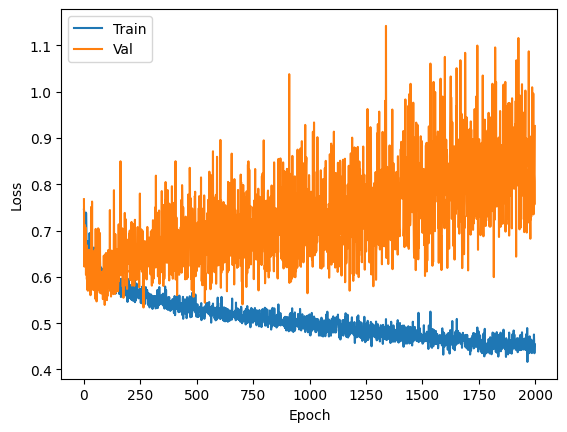

In [358]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [359]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.
y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

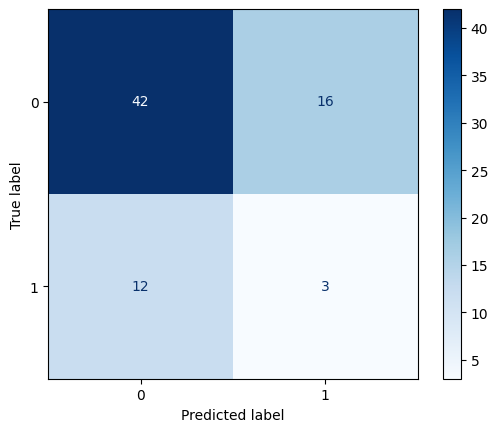

Accuracy: 0.6164
Precision: 0.1579
Recall: 0.2000
f1 score: 0.1765


In [360]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [361]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        return x

model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

341,830
GAT model number of params: 341,830


In [362]:
weight = torch.Tensor([1.0, 2.5])
log_softmax = torch.nn.LogSoftmax(dim=1)
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 2000
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask].squeeze()
    loss = criterion(log_softmax(preds), data.y[data.train_mask].to(dtype=torch.long))  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask].squeeze()
        v_loss = criterion(log_softmax(v_preds), data.y[data.val_mask].to(dtype=torch.long))
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7044 / Val_loss: 0.7030
Epoch: 002, Train_loss: 0.6923 / Val_loss: 0.6954
Epoch: 003, Train_loss: 0.6942 / Val_loss: 0.6838
Epoch: 004, Train_loss: 0.6836 / Val_loss: 0.6807
Epoch: 005, Train_loss: 0.6820 / Val_loss: 0.6838
Epoch: 006, Train_loss: 0.6775 / Val_loss: 0.6795
Epoch: 007, Train_loss: 0.6724 / Val_loss: 0.6800
Epoch: 008, Train_loss: 0.6679 / Val_loss: 0.6735
Epoch: 009, Train_loss: 0.6723 / Val_loss: 0.6699
Epoch: 010, Train_loss: 0.6673 / Val_loss: 0.6732
Epoch: 011, Train_loss: 0.6627 / Val_loss: 0.6657
Epoch: 012, Train_loss: 0.6579 / Val_loss: 0.6723
Epoch: 013, Train_loss: 0.6567 / Val_loss: 0.6713
Epoch: 014, Train_loss: 0.6530 / Val_loss: 0.6662
Epoch: 015, Train_loss: 0.6546 / Val_loss: 0.6656
Epoch: 016, Train_loss: 0.6481 / Val_loss: 0.6637
Epoch: 017, Train_loss: 0.6553 / Val_loss: 0.6546
Epoch: 018, Train_loss: 0.6518 / Val_loss: 0.6648
Epoch: 019, Train_loss: 0.6465 / Val_loss: 0.6663
Epoch: 020, Train_loss: 0.6508 / Val_loss: 0.6672


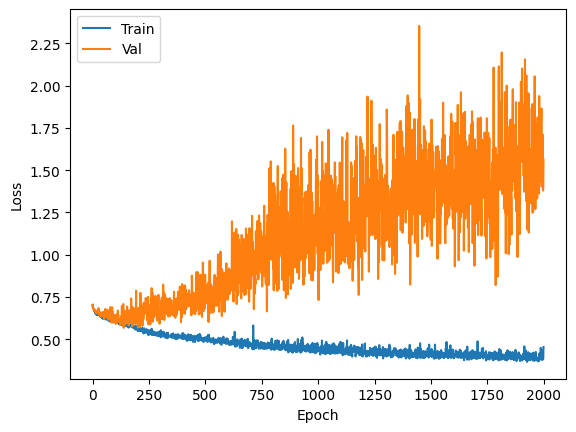

In [363]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [364]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.
y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

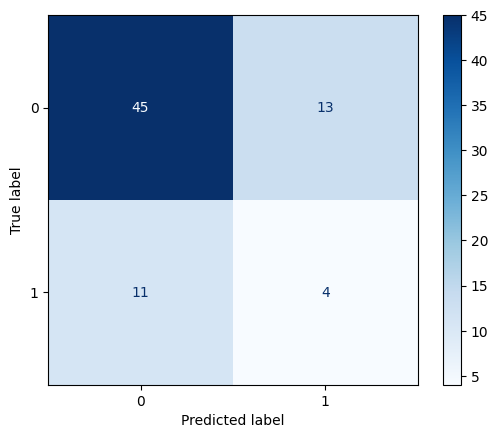

Accuracy: 0.6712
Precision: 0.2353
Recall: 0.2667
f1 score: 0.2500


In [365]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [368]:
sum(y) / len(y)

np.float64(0.19334719334719336)